# Read Respose

Definitions And Constant

In [2]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
import numpy as np
from src.utils.imgutils import *
import src.constants as constants
from src.config import CONFIG_DEFAULTS as config
from src.logger import logger
import src.template2  as t
from src.processors.manager import ProcessorManager
PROCESSOR_MANAGER = ProcessorManager()
def normalize_util(img, alpha=0, beta=255):
    return cv2.normalize(img, alpha, beta, norm_type=cv2.NORM_MINMAX)

[13:51:34] INFO     Looking for processors in "src.processors"                                         ]8;id=130565;file:///home/jovyan/src/logger.py\logger.py]8;;\:]8;id=954503;file:///home/jovyan/src/logger.py#50\50]8;;\

           INFO     Loaded processors: ['CropOnMarkers', 'CropPage', 'FeatureBasedAlignment',          ]8;id=600010;file:///home/jovyan/src/logger.py\logger.py]8;;\:]8;id=874525;file:///home/jovyan/src/logger.py#50\50]8;;\
                    'GaussianBlur', 'Levels']                                                                      

Function Read Respose input Template.py  and image after preprocoessimg <br />
1- Resize image to Dimension in Template <br />
2-calculates Mean of pixals in esch squer in box
3-calculate standar devition to vals of mean squar 

In [14]:
def read_response(template,image, name, save_dir=None):
            img = image.copy()
           
            img = ImageUtils.resize_util(
                img, template.dimensions[0], template.dimensions[1]
            )
            if img.max() > img.min():
                img = normalize_util(img)
            
            transp_layer = img.copy()
            final_marked = img.copy()
            morph = img.copy()
            ImageUtils.append_save_img(3, morph)
            alpha = 0.65
            box_w, box_h = template.bubble_dimensions
            omr_response = {}
            multi_marked, multi_roll = 0, 0
            if config.outputs.show_image_level >= 5:
                all_c_box_vals = {"int": [], "mcq": []}
                # ,"QTYPE_ROLL":[]}#,"QTYPE_MED":[]}
                q_nums = {"int": [], "mcq": []}
                
            final_align = None
            if config.outputs.show_image_level >= 2:
                initial_align = ImageUtils.draw_template_layout(img, template, shifted=False)
                final_align = ImageUtils.draw_template_layout(
                    img, template, shifted=True, draw_qvals=True
                )
            all_q_vals, all_q_strip_arrs, all_q_std_vals = [], [], []
            total_q_strip_no = 0
            for q_block in template.q_blocks:
                q_std_vals = []
                for _, qbox_pts in q_block.traverse_pts:
                    q_strip_vals = []
                    for pt in qbox_pts:
                        # shifted
                        x, y = (pt.x + q_block.shift, pt.y)
                        rect = [y, y + box_h, x, x + box_w]
                        vv = cv2.mean(img[rect[0] : rect[1], rect[2] : rect[3]])[0]
                        display("The mean of all pixal in squar {} in box {} = {}".format(pt.val,pt.q_no ,vv))
                        q_strip_vals.append(
                            vv
                        )
                    ss = round(np.std(q_strip_vals), 2)
                    q_std_vals.append(ss)
                    display("The standar Devition each Col = {} in block {}".format(ss ,qbox_pts[0].q_no ))
                    all_q_strip_arrs.append(q_strip_vals)
                    all_q_vals.extend(q_strip_vals)
                    total_q_strip_no += 1
                all_q_std_vals.extend(q_std_vals)
            global_std_thresh, _, _ = get_global_threshold(
                all_q_std_vals
            ) 
            global_thr, _, _ = get_global_threshold(all_q_vals, looseness=4)
            # TODO colorama
            logger.info(
                "Thresholding:\t\t global_thr: ",
                round(global_thr, 2),
                "\tglobal_std_THR that used codution no_outliers: ",
                round(global_std_thresh, 2),
                "\t(Looks like a Xeroxed OMR)" if (global_thr == 255) else "",
            )
    
            per_omr_threshold_avg, total_q_strip_no, total_q_box_no = 0, 0, 0
            non_empty_qnos = set()
            for q_block in template.q_blocks:
                block_q_strip_no = 1
                shift = q_block.shift
                s, d = q_block.orig, q_block.dimensions
                key = q_block.key[:3]
                for _, qbox_pts in q_block.traverse_pts:
                    # All Black or All White case
                    no_outliers = all_q_std_vals[total_q_strip_no] < global_std_thresh
                    per_q_strip_threshold = get_local_threshold(
                        all_q_strip_arrs[total_q_strip_no],
                        global_thr,
                        no_outliers,
                        "Mean Intensity Histogram for "
                        + key
                        + "."
                        + qbox_pts[0].q_no
                        + "."
                        + str(block_q_strip_no),
                        config.outputs.show_image_level >= 6,
                    )
                    per_omr_threshold_avg += per_q_strip_threshold
                    display("per_omr_threshold_avg = {}".format(per_omr_threshold_avg))
                    for pt in qbox_pts:
                        # shifted
                        x, y = (pt.x + q_block.shift, pt.y)
                        boxval0 = all_q_vals[total_q_box_no]
                        detected = per_q_strip_threshold > boxval0
                        display("check if block dark or no :{}".format(detected))
                        if detected:
                            cv2.rectangle(
                                final_marked,
                                (int(x + box_w / 12), int(y + box_h / 12)),
                                (
                                    int(x + box_w - box_w / 12),
                                    int(y + box_h - box_h / 12),
                                ),
                                constants.CLR_DARK_GRAY,
                                3,
                            )
                        else:
                            cv2.rectangle(
                                final_marked,
                                (int(x + box_w / 10), int(y + box_h / 10)),
                                (
                                    int(x + box_w - box_w / 10),
                                    int(y + box_h - box_h / 10),
                                ),
                                constants.CLR_GRAY,
                                -1,
                            )

                        if detected:
                            q, val = pt.q_no, str(pt.val)
                            cv2.putText(
                                final_marked,
                                val,
                                (x, y),
                                cv2.FONT_HERSHEY_SIMPLEX,
                                constants.TEXT_SIZE,
                                (20, 20, 10),
                                int(1 + 3.5 * constants.TEXT_SIZE),
                            )
                            multi_marked_l = q in omr_response
                            multi_marked = multi_marked_l or multi_marked
                            omr_response[q] = (
                                (omr_response[q] + val) if multi_marked_l else val
                            )
                            non_empty_qnos.add(q)
                            multi_roll = multi_marked_l and "Roll" in str(q)
                        total_q_box_no += 1      
                    if config.outputs.show_image_level >= 5:
                        if key in all_c_box_vals:
                            q_nums[key].append(key[:2] + "_c" + str(block_q_strip_no))
                            all_c_box_vals[key].append(
                                all_q_strip_arrs[total_q_strip_no]
                            )

                    block_q_strip_no += 1
                    total_q_strip_no += 1
            for concatQ in template.concatenations:
                for q in concatQ:
                    if q not in non_empty_qnos:
                        omr_response[q] = q_block.empty_val
            for q in template.singles:
                if q not in non_empty_qnos:
                    omr_response[q] = q_block.empty_val
            per_omr_threshold_avg /= total_q_strip_no
            per_omr_threshold_avg = round(per_omr_threshold_avg, 2)
            cv2.addWeighted(
                final_marked, alpha, transp_layer, 1 - alpha, 0, final_marked
            )
            if config.outputs.show_image_level >= 5:
                # plt.draw()
                f, axes = plt.subplots(len(all_c_box_vals), sharey=True)
                f.canvas.manager.set_window_title(name)
                ctr = 0
                type_name = {
                    "int": "Integer",
                    "mcq": "MCQ",
                    "med": "MED",
                    "rol": "Roll",
                }
                for k, boxvals in all_c_box_vals.items():
                    axes[ctr].title.set_text(type_name[k] + " Type")
                    axes[ctr].boxplot(boxvals)
                    axes[ctr].set_ylabel("Intensity")
                    axes[ctr].set_xticklabels(q_nums[k])
                    ctr += 1
                plt.tight_layout(pad=0.5)
                plt.show()
            return omr_response, final_marked, multi_marked, multi_roll


# Input

[14:04:32] INFO     Validating template.json ...                                                         ]8;id=905311;file:///home/jovyan/src/utils/file.py\file.py]8;;\:]8;id=907749;file:///home/jovyan/src/utils/file.py#25\25]8;;\

           INFO     Template JSON validated successfully...                                            ]8;id=75166;file:///home/jovyan/src/logger.py\logger.py]8;;\:]8;id=249001;file:///home/jovyan/src/logger.py#50\50]8;;\

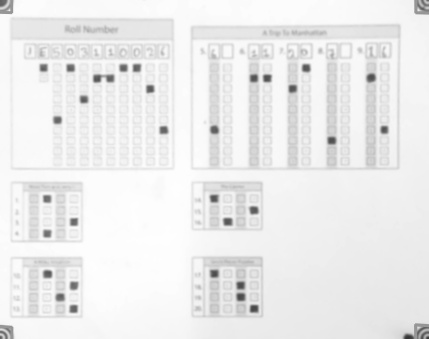

In [15]:

name = "sheet1.jpg" # name of image
image = cv2.imread("result_image.jpg")
# ⛔️ AttributeError: module 'json' has no attribute 'loads'
template = t.Template
template.__init__(template,"samples/sample1/template.json",PROCESSOR_MANAGER.processors)
display(Image.fromarray(image))

# Output

'The mean of all pixal in squar E in box Medium = 148.13625'

'The mean of all pixal in squar H in box Medium = 233.446875'

'The standar Devition each Col = 42.66 in block Medium'

'The mean of all pixal in squar 0 in box roll0 = 234.173125'

'The mean of all pixal in squar 1 in box roll0 = 234.50375'

'The mean of all pixal in squar 2 in box roll0 = 234.98875'

'The mean of all pixal in squar 3 in box roll0 = 235.800625'

'The mean of all pixal in squar 4 in box roll0 = 233.345'

'The mean of all pixal in squar 5 in box roll0 = 149.581875'

'The mean of all pixal in squar 6 in box roll0 = 234.9925'

'The mean of all pixal in squar 7 in box roll0 = 236.054375'

'The mean of all pixal in squar 8 in box roll0 = 234.144375'

'The mean of all pixal in squar 9 in box roll0 = 235.956875'

'The standar Devition each Col = 25.6 in block roll0'

'The mean of all pixal in squar 0 in box roll1 = 142.7225'

'The mean of all pixal in squar 1 in box roll1 = 232.2525'

'The mean of all pixal in squar 2 in box roll1 = 233.1875'

'The mean of all pixal in squar 3 in box roll1 = 233.951875'

'The mean of all pixal in squar 4 in box roll1 = 233.865625'

'The mean of all pixal in squar 5 in box roll1 = 234.35375'

'The mean of all pixal in squar 6 in box roll1 = 234.644375'

'The mean of all pixal in squar 7 in box roll1 = 235.14375'

'The mean of all pixal in squar 8 in box roll1 = 233.8175'

'The mean of all pixal in squar 9 in box roll1 = 235.71375'

'The standar Devition each Col = 27.43 in block roll1'

'The mean of all pixal in squar 0 in box roll2 = 232.3125'

'The mean of all pixal in squar 1 in box roll2 = 231.945'

'The mean of all pixal in squar 2 in box roll2 = 230.87'

'The mean of all pixal in squar 3 in box roll2 = 139.099375'

'The mean of all pixal in squar 4 in box roll2 = 233.515625'

'The mean of all pixal in squar 5 in box roll2 = 234.988125'

'The mean of all pixal in squar 6 in box roll2 = 234.73375000000001'

'The mean of all pixal in squar 7 in box roll2 = 235.553125'

'The mean of all pixal in squar 8 in box roll2 = 233.6575'

'The mean of all pixal in squar 9 in box roll2 = 234.92875'

'The standar Devition each Col = 28.39 in block roll2'

'The mean of all pixal in squar 0 in box roll3 = 229.53625'

'The mean of all pixal in squar 1 in box roll3 = 127.42812500000001'

'The mean of all pixal in squar 2 in box roll3 = 232.10625000000002'

'The mean of all pixal in squar 3 in box roll3 = 231.85375'

'The mean of all pixal in squar 4 in box roll3 = 231.22375'

'The mean of all pixal in squar 5 in box roll3 = 234.063125'

'The mean of all pixal in squar 6 in box roll3 = 232.71625'

'The mean of all pixal in squar 7 in box roll3 = 234.825625'

'The mean of all pixal in squar 8 in box roll3 = 232.3725'

'The mean of all pixal in squar 9 in box roll3 = 234.46437500000002'

'The standar Devition each Col = 31.58 in block roll3'

'The mean of all pixal in squar 0 in box roll4 = 231.546875'

'The mean of all pixal in squar 1 in box roll4 = 129.023125'

'The mean of all pixal in squar 2 in box roll4 = 231.505625'

'The mean of all pixal in squar 3 in box roll4 = 232.610625'

'The mean of all pixal in squar 4 in box roll4 = 233.204375'

'The mean of all pixal in squar 5 in box roll4 = 233.35'

'The mean of all pixal in squar 6 in box roll4 = 233.83375'

'The mean of all pixal in squar 7 in box roll4 = 235.510625'

'The mean of all pixal in squar 8 in box roll4 = 233.77375'

'The mean of all pixal in squar 9 in box roll4 = 235.28625'

'The standar Devition each Col = 31.34 in block roll4'

'The mean of all pixal in squar 0 in box roll5 = 134.7125'

'The mean of all pixal in squar 1 in box roll5 = 231.78375'

'The mean of all pixal in squar 2 in box roll5 = 231.52'

'The mean of all pixal in squar 3 in box roll5 = 232.928125'

'The mean of all pixal in squar 4 in box roll5 = 233.195625'

'The mean of all pixal in squar 5 in box roll5 = 234.12375'

'The mean of all pixal in squar 6 in box roll5 = 234.984375'

'The mean of all pixal in squar 7 in box roll5 = 235.4425'

'The mean of all pixal in squar 8 in box roll5 = 233.76250000000002'

'The mean of all pixal in squar 9 in box roll5 = 235.68437500000002'

'The standar Devition each Col = 29.73 in block roll5'

'The mean of all pixal in squar 0 in box roll6 = 128.584375'

'The mean of all pixal in squar 1 in box roll6 = 230.775'

'The mean of all pixal in squar 2 in box roll6 = 231.818125'

'The mean of all pixal in squar 3 in box roll6 = 231.331875'

'The mean of all pixal in squar 4 in box roll6 = 232.84312500000001'

'The mean of all pixal in squar 5 in box roll6 = 232.8725'

'The mean of all pixal in squar 6 in box roll6 = 234.22875'

'The mean of all pixal in squar 7 in box roll6 = 234.5075'

'The mean of all pixal in squar 8 in box roll6 = 233.881875'

'The mean of all pixal in squar 9 in box roll6 = 234.140625'

'The standar Devition each Col = 31.33 in block roll6'

'The mean of all pixal in squar 0 in box roll7 = 231.19625'

'The mean of all pixal in squar 1 in box roll7 = 230.54625000000001'

'The mean of all pixal in squar 2 in box roll7 = 125.265625'

'The mean of all pixal in squar 3 in box roll7 = 230.196875'

'The mean of all pixal in squar 4 in box roll7 = 231.98000000000002'

'The mean of all pixal in squar 5 in box roll7 = 232.115'

'The mean of all pixal in squar 6 in box roll7 = 232.5525'

'The mean of all pixal in squar 7 in box roll7 = 233.83375'

'The mean of all pixal in squar 8 in box roll7 = 232.8375'

'The mean of all pixal in squar 9 in box roll7 = 234.898125'

'The standar Devition each Col = 32.12 in block roll7'

'The mean of all pixal in squar 0 in box roll8 = 232.081875'

'The mean of all pixal in squar 1 in box roll8 = 232.323125'

'The mean of all pixal in squar 2 in box roll8 = 232.5325'

'The mean of all pixal in squar 3 in box roll8 = 231.459375'

'The mean of all pixal in squar 4 in box roll8 = 230.96375'

'The mean of all pixal in squar 5 in box roll8 = 230.619375'

'The mean of all pixal in squar 6 in box roll8 = 130.024375'

'The mean of all pixal in squar 7 in box roll8 = 233.895625'

'The mean of all pixal in squar 8 in box roll8 = 232.781875'

'The mean of all pixal in squar 9 in box roll8 = 235.054375'

'The standar Devition each Col = 30.74 in block roll8'

'The mean of all pixal in squar 0 in box q5.1 = 206.99562500000002'

'The mean of all pixal in squar 1 in box q5.1 = 209.19375'

'The mean of all pixal in squar 2 in box q5.1 = 207.565'

'The mean of all pixal in squar 3 in box q5.1 = 208.366875'

'The mean of all pixal in squar 4 in box q5.1 = 206.786875'

'The mean of all pixal in squar 5 in box q5.1 = 203.55937500000002'

'The mean of all pixal in squar 6 in box q5.1 = 116.47437500000001'

'The mean of all pixal in squar 7 in box q5.1 = 206.079375'

'The mean of all pixal in squar 8 in box q5.1 = 205.6275'

'The mean of all pixal in squar 9 in box q5.1 = 204.439375'

'The standar Devition each Col = 27.06 in block q5.1'

'The mean of all pixal in squar 0 in box q5.2 = 228.898125'

'The mean of all pixal in squar 1 in box q5.2 = 229.1975'

'The mean of all pixal in squar 2 in box q5.2 = 229.585625'

'The mean of all pixal in squar 3 in box q5.2 = 228.849375'

'The mean of all pixal in squar 4 in box q5.2 = 229.486875'

'The mean of all pixal in squar 5 in box q5.2 = 228.17375'

'The mean of all pixal in squar 6 in box q5.2 = 227.566875'

'The mean of all pixal in squar 7 in box q5.2 = 228.75125'

'The mean of all pixal in squar 8 in box q5.2 = 226.2675'

'The mean of all pixal in squar 9 in box q5.2 = 227.6875'

'The standar Devition each Col = 0.98 in block q5.2'

'The mean of all pixal in squar 0 in box q6.1 = 201.861875'

'The mean of all pixal in squar 1 in box q6.1 = 114.00625000000001'

'The mean of all pixal in squar 2 in box q6.1 = 202.86375'

'The mean of all pixal in squar 3 in box q6.1 = 204.465'

'The mean of all pixal in squar 4 in box q6.1 = 202.82625000000002'

'The mean of all pixal in squar 5 in box q6.1 = 204.62625'

'The mean of all pixal in squar 6 in box q6.1 = 203.478125'

'The mean of all pixal in squar 7 in box q6.1 = 203.68687500000001'

'The mean of all pixal in squar 8 in box q6.1 = 201.275625'

'The mean of all pixal in squar 9 in box q6.1 = 200.46687500000002'

'The standar Devition each Col = 26.68 in block q6.1'

'The mean of all pixal in squar 0 in box q6.2 = 226.70375'

'The mean of all pixal in squar 1 in box q6.2 = 121.885'

'The mean of all pixal in squar 2 in box q6.2 = 227.929375'

'The mean of all pixal in squar 3 in box q6.2 = 227.99125'

'The mean of all pixal in squar 4 in box q6.2 = 227.79875'

'The mean of all pixal in squar 5 in box q6.2 = 227.955625'

'The mean of all pixal in squar 6 in box q6.2 = 226.796875'

'The mean of all pixal in squar 7 in box q6.2 = 228.19875000000002'

'The mean of all pixal in squar 8 in box q6.2 = 226.70125000000002'

'The mean of all pixal in squar 9 in box q6.2 = 226.35375'

'The standar Devition each Col = 31.66 in block q6.2'

'The mean of all pixal in squar 0 in box q7.1 = 210.27375'

'The mean of all pixal in squar 1 in box q7.1 = 210.24937500000001'

'The mean of all pixal in squar 2 in box q7.1 = 135.494375'

'The mean of all pixal in squar 3 in box q7.1 = 209.915'

'The mean of all pixal in squar 4 in box q7.1 = 207.8625'

'The mean of all pixal in squar 5 in box q7.1 = 209.85625000000002'

'The mean of all pixal in squar 6 in box q7.1 = 208.86375'

'The mean of all pixal in squar 7 in box q7.1 = 208.54500000000002'

'The mean of all pixal in squar 8 in box q7.1 = 207.05375'

'The mean of all pixal in squar 9 in box q7.1 = 206.11'

'The standar Devition each Col = 22.02 in block q7.1'

'The mean of all pixal in squar 0 in box q7.2 = 145.918125'

'The mean of all pixal in squar 1 in box q7.2 = 231.031875'

'The mean of all pixal in squar 2 in box q7.2 = 231.069375'

'The mean of all pixal in squar 3 in box q7.2 = 230.219375'

'The mean of all pixal in squar 4 in box q7.2 = 229.241875'

'The mean of all pixal in squar 5 in box q7.2 = 228.93437500000002'

'The mean of all pixal in squar 6 in box q7.2 = 229.500625'

'The mean of all pixal in squar 7 in box q7.2 = 229.514375'

'The mean of all pixal in squar 8 in box q7.2 = 228.020625'

'The mean of all pixal in squar 9 in box q7.2 = 227.669375'

'The standar Devition each Col = 25.09 in block q7.2'

'The mean of all pixal in squar 0 in box q8.1 = 208.198125'

'The mean of all pixal in squar 1 in box q8.1 = 209.26875'

'The mean of all pixal in squar 2 in box q8.1 = 206.99375'

'The mean of all pixal in squar 3 in box q8.1 = 206.47375'

'The mean of all pixal in squar 4 in box q8.1 = 205.300625'

'The mean of all pixal in squar 5 in box q8.1 = 206.085'

'The mean of all pixal in squar 6 in box q8.1 = 202.399375'

'The mean of all pixal in squar 7 in box q8.1 = 127.439375'

'The mean of all pixal in squar 8 in box q8.1 = 201.25625'

'The mean of all pixal in squar 9 in box q8.1 = 201.190625'

'The standar Devition each Col = 23.49 in block q8.1'

'The mean of all pixal in squar 0 in box q8.2 = 228.65625'

'The mean of all pixal in squar 1 in box q8.2 = 229.71687500000002'

'The mean of all pixal in squar 2 in box q8.2 = 229.900625'

'The mean of all pixal in squar 3 in box q8.2 = 228.98375000000001'

'The mean of all pixal in squar 4 in box q8.2 = 227.55812500000002'

'The mean of all pixal in squar 5 in box q8.2 = 228.368125'

'The mean of all pixal in squar 6 in box q8.2 = 225.959375'

'The mean of all pixal in squar 7 in box q8.2 = 225.540625'

'The mean of all pixal in squar 8 in box q8.2 = 224.37312500000002'

'The mean of all pixal in squar 9 in box q8.2 = 223.814375'

'The standar Devition each Col = 2.1 in block q8.2'

'The mean of all pixal in squar 0 in box q9.1 = 207.408125'

'The mean of all pixal in squar 1 in box q9.1 = 143.836875'

'The mean of all pixal in squar 2 in box q9.1 = 211.01875'

'The mean of all pixal in squar 3 in box q9.1 = 210.80937500000002'

'The mean of all pixal in squar 4 in box q9.1 = 209.12125'

'The mean of all pixal in squar 5 in box q9.1 = 209.348125'

'The mean of all pixal in squar 6 in box q9.1 = 206.429375'

'The mean of all pixal in squar 7 in box q9.1 = 205.6225'

'The mean of all pixal in squar 8 in box q9.1 = 204.206875'

'The mean of all pixal in squar 9 in box q9.1 = 204.465'

'The standar Devition each Col = 19.27 in block q9.1'

'The mean of all pixal in squar 0 in box q9.2 = 230.965'

'The mean of all pixal in squar 1 in box q9.2 = 230.819375'

'The mean of all pixal in squar 2 in box q9.2 = 230.18562500000002'

'The mean of all pixal in squar 3 in box q9.2 = 230.215'

'The mean of all pixal in squar 4 in box q9.2 = 228.71812500000001'

'The mean of all pixal in squar 5 in box q9.2 = 227.190625'

'The mean of all pixal in squar 6 in box q9.2 = 171.51250000000002'

'The mean of all pixal in squar 7 in box q9.2 = 226.40562500000001'

'The mean of all pixal in squar 8 in box q9.2 = 225.200625'

'The mean of all pixal in squar 9 in box q9.2 = 224.763125'

'The standar Devition each Col = 17.17 in block q9.2'

'The mean of all pixal in squar A in box q1 = 211.34187500000002'

'The mean of all pixal in squar A in box q2 = 214.315'

'The mean of all pixal in squar A in box q3 = 213.565'

'The mean of all pixal in squar A in box q4 = 212.049375'

'The standar Devition each Col = 1.18 in block q1'

'The mean of all pixal in squar B in box q1 = 145.020625'

'The mean of all pixal in squar B in box q2 = 233.40625'

'The mean of all pixal in squar B in box q3 = 233.20375'

'The mean of all pixal in squar B in box q4 = 147.83875'

'The standar Devition each Col = 43.45 in block q1'

'The mean of all pixal in squar C in box q1 = 210.258125'

'The mean of all pixal in squar C in box q2 = 212.230625'

'The mean of all pixal in squar C in box q3 = 210.71'

'The mean of all pixal in squar C in box q4 = 212.64000000000001'

'The standar Devition each Col = 1.0 in block q1'

'The mean of all pixal in squar D in box q1 = 232.27'

'The mean of all pixal in squar D in box q2 = 233.54125'

'The mean of all pixal in squar D in box q3 = 134.785625'

'The mean of all pixal in squar D in box q4 = 233.46437500000002'

'The standar Devition each Col = 42.57 in block q1'

'The mean of all pixal in squar A in box q10 = 212.069375'

'The mean of all pixal in squar A in box q11 = 212.1625'

'The mean of all pixal in squar A in box q12 = 210.73250000000002'

'The mean of all pixal in squar A in box q13 = 210.221875'

'The standar Devition each Col = 0.84 in block q10'

'The mean of all pixal in squar B in box q10 = 132.84375'

'The mean of all pixal in squar B in box q11 = 231.67125000000001'

'The mean of all pixal in squar B in box q12 = 233.01375000000002'

'The mean of all pixal in squar B in box q13 = 232.62187500000002'

'The standar Devition each Col = 43.13 in block q10'

'The mean of all pixal in squar C in box q10 = 210.46812500000001'

'The mean of all pixal in squar C in box q11 = 210.004375'

'The mean of all pixal in squar C in box q12 = 130.396875'

'The mean of all pixal in squar C in box q13 = 208.115625'

'The standar Devition each Col = 34.28 in block q10'

'The mean of all pixal in squar D in box q10 = 232.610625'

'The mean of all pixal in squar D in box q11 = 138.54500000000002'

'The mean of all pixal in squar D in box q12 = 233.6175'

'The mean of all pixal in squar D in box q13 = 143.59062500000002'

'The standar Devition each Col = 46.06 in block q10'

'The mean of all pixal in squar A in box q14 = 112.19'

'The mean of all pixal in squar A in box q15 = 202.95125000000002'

'The mean of all pixal in squar A in box q16 = 200.5975'

'The standar Devition each Col = 42.24 in block q14'

'The mean of all pixal in squar B in box q14 = 222.25'

'The mean of all pixal in squar B in box q15 = 222.62625'

'The mean of all pixal in squar B in box q16 = 114.0725'

'The standar Devition each Col = 51.08 in block q14'

'The mean of all pixal in squar C in box q14 = 203.080625'

'The mean of all pixal in squar C in box q15 = 201.8425'

'The mean of all pixal in squar C in box q16 = 200.89625'

'The standar Devition each Col = 0.89 in block q14'

'The mean of all pixal in squar D in box q14 = 220.954375'

'The mean of all pixal in squar D in box q15 = 127.9525'

'The mean of all pixal in squar D in box q16 = 220.674375'

'The standar Devition each Col = 43.78 in block q14'

'The mean of all pixal in squar A in box q17 = 110.504375'

'The mean of all pixal in squar A in box q18 = 193.394375'

'The mean of all pixal in squar A in box q19 = 194.203125'

'The mean of all pixal in squar A in box q20 = 191.20250000000001'

'The standar Devition each Col = 35.71 in block q17'

'The mean of all pixal in squar B in box q17 = 216.95375'

'The mean of all pixal in squar B in box q18 = 216.105625'

'The mean of all pixal in squar B in box q19 = 215.043125'

'The mean of all pixal in squar B in box q20 = 214.39875'

'The standar Devition each Col = 0.98 in block q17'

'The mean of all pixal in squar C in box q17 = 193.878125'

'The mean of all pixal in squar C in box q18 = 117.643125'

'The mean of all pixal in squar C in box q19 = 114.83625'

'The mean of all pixal in squar C in box q20 = 191.51250000000002'

'The standar Devition each Col = 38.25 in block q17'

'The mean of all pixal in squar D in box q17 = 215.40125'

'The mean of all pixal in squar D in box q18 = 215.293125'

'The mean of all pixal in squar D in box q19 = 213.9225'

'The mean of all pixal in squar D in box q20 = 131.045625'

'The standar Devition each Col = 36.3 in block q17'

[14:04:37] INFO     Thresholding:            global_thr:  171.49    global_std_THR that used codution  ]8;id=816407;file:///home/jovyan/src/logger.py\logger.py]8;;\:]8;id=279348;file:///home/jovyan/src/logger.py#50\50]8;;\
                    no_outliers:  200                                                                              

'per_omr_threshold_avg = 190.7915625'

'check if block dark or no :True'

'check if block dark or no :False'

'per_omr_threshold_avg = 382.6546875'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :True'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 570.6096875000001'

'check if block dark or no :True'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 756.131875'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :True'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 935.4578125'

'check if block dark or no :False'

'check if block dark or no :True'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 1115.7428125000001'

'check if block dark or no :False'

'check if block dark or no :True'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 1298.9909375000002'

'check if block dark or no :True'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 1478.9490625000003'

'check if block dark or no :True'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 1656.8550000000002'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :True'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 1837.3490625000002'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :True'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 1997.8059375000003'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :True'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 2169.2940625'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 2326.935'

'check if block dark or no :False'

'check if block dark or no :True'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 2501.228125'

'check if block dark or no :False'

'check if block dark or no :True'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 2672.5021875'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :True'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 2859.4715625000003'

'check if block dark or no :True'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 3023.8193750000005'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :True'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 3195.3075000000003'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 3369.4584375000004'

'check if block dark or no :False'

'check if block dark or no :True'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 3567.8150000000005'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :True'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 3739.3031250000004'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 3928.4153125000003'

'check if block dark or no :True'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :True'

'per_omr_threshold_avg = 4099.9034375'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 4284.0284375'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :True'

'check if block dark or no :False'

'per_omr_threshold_avg = 4455.5165625'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 4638.249375'

'check if block dark or no :True'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 4808.450000000001'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :True'

'check if block dark or no :False'

'per_omr_threshold_avg = 4994.0278125'

'check if block dark or no :False'

'check if block dark or no :True'

'check if block dark or no :False'

'check if block dark or no :True'

'per_omr_threshold_avg = 5151.598437500001'

'check if block dark or no :True'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 5319.9478125000005'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :True'

'per_omr_threshold_avg = 5491.4359375'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 5665.889375000001'

'check if block dark or no :False'

'check if block dark or no :True'

'check if block dark or no :False'

'per_omr_threshold_avg = 5817.838750000001'

'check if block dark or no :True'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 5989.326875000001'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'per_omr_threshold_avg = 6142.50125'

'check if block dark or no :False'

'check if block dark or no :True'

'check if block dark or no :True'

'check if block dark or no :False'

'per_omr_threshold_avg = 6315.670625000001'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :False'

'check if block dark or no :True'

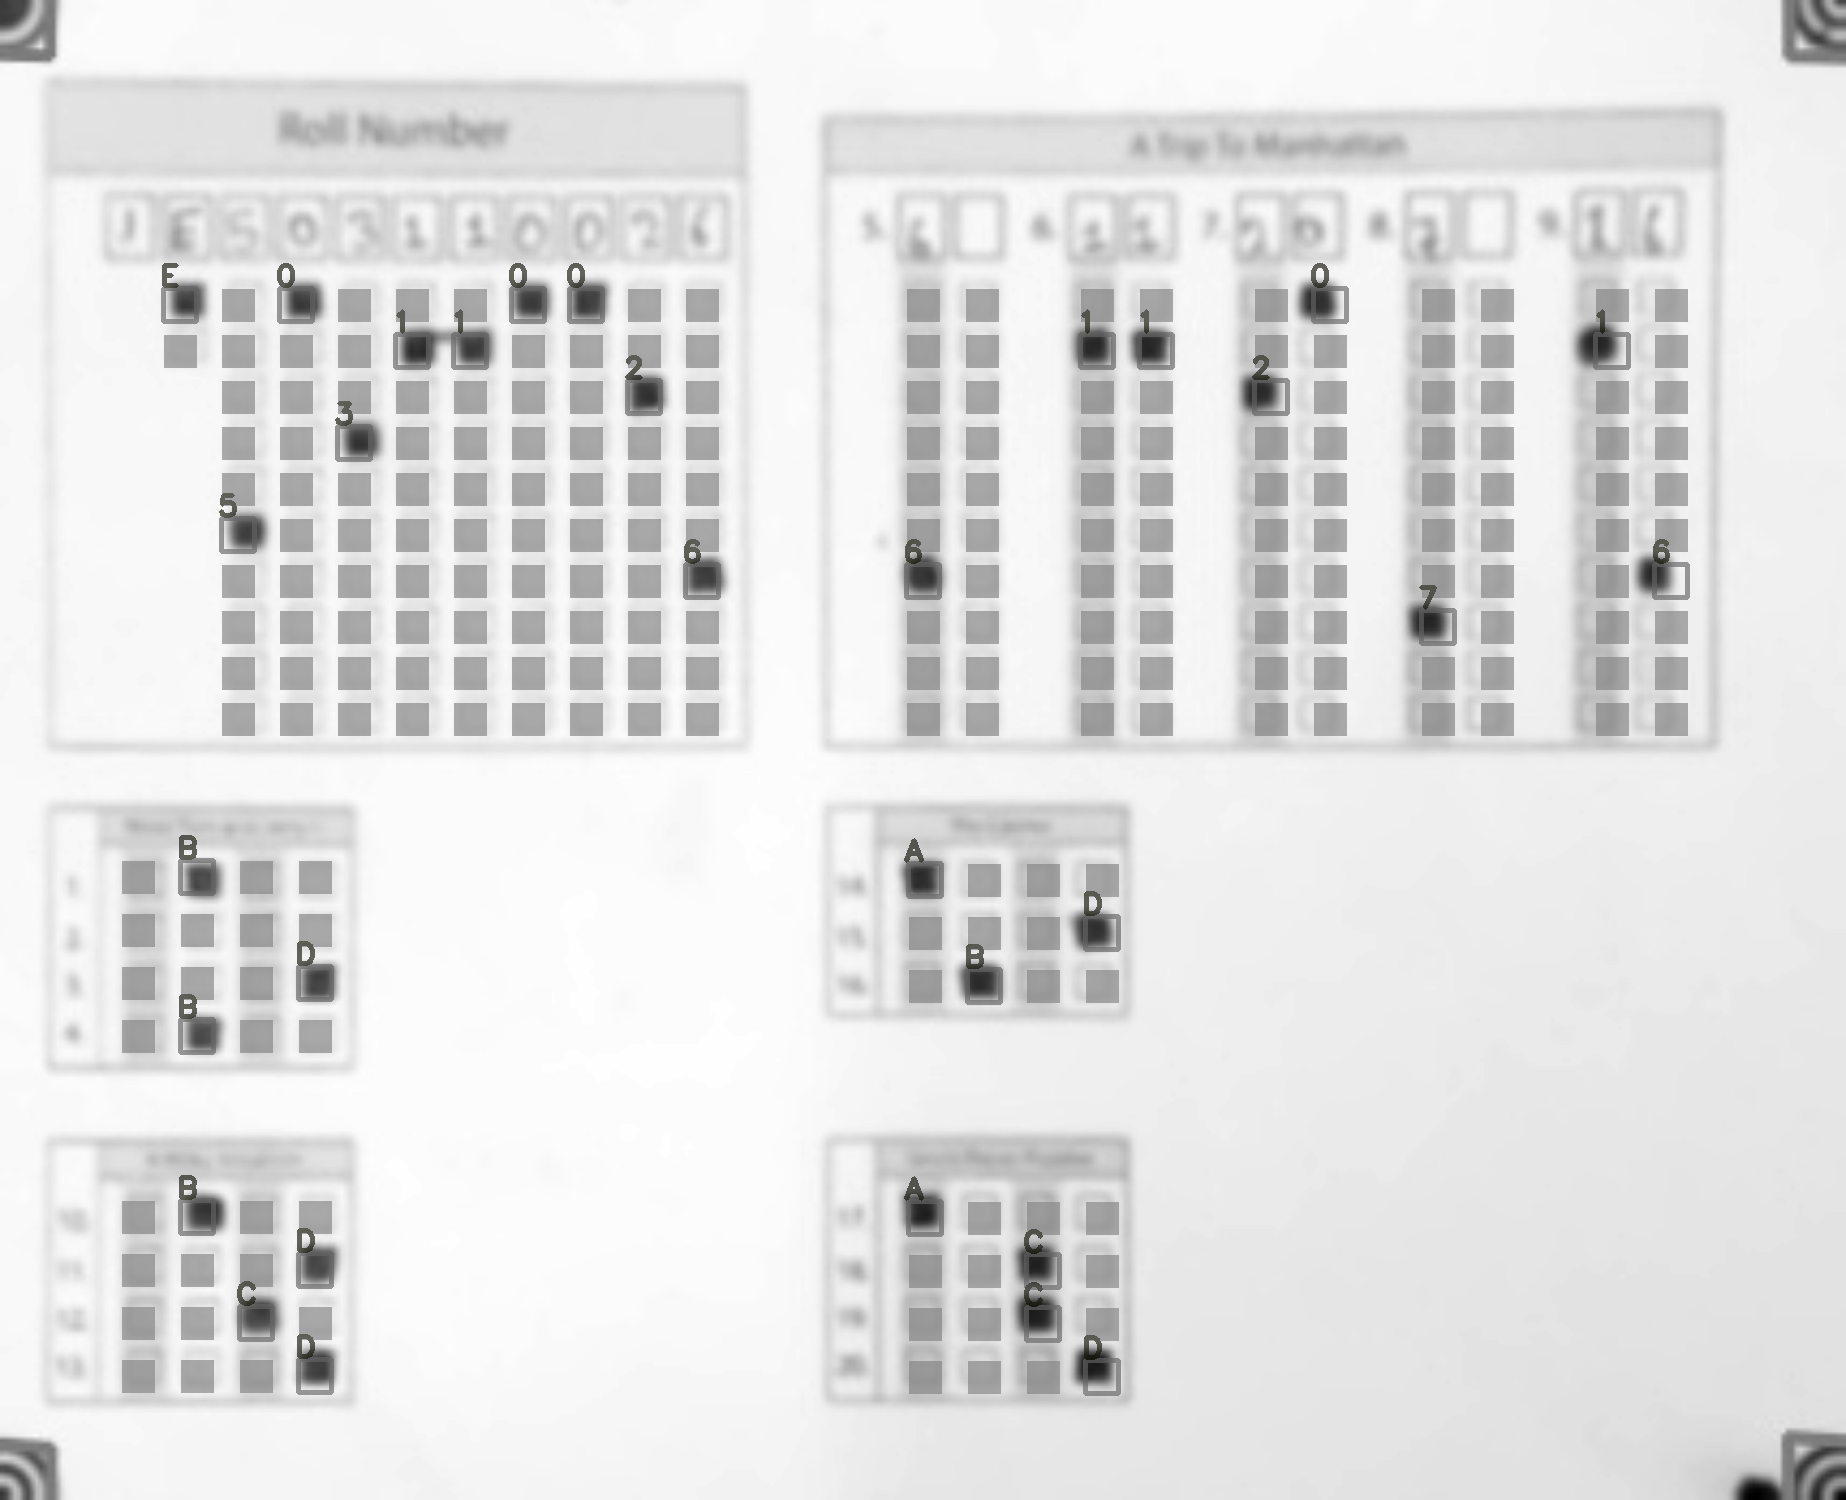

In [16]:
omr_response, final_marked, multi_marked, multi_roll=read_response(template,image, name, save_dir=None)
display(Image.fromarray(final_marked))